In [1]:
from pathlib import Path
import pickle
import datetime as dt
import numpy as np
import pandas as pd
import scipy as sp
import json
import matplotlib.pyplot as plt
# import boto3

from typing import List
# from random import choices
from IPython.display import display
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
SEED = 1426

# Initial data distribution
mean = [0, 0, 0, 0,]

cov1 = [
    [4, 0, 0, 0,],
    [0, 4, 0, 0,],
    [0, 0, 4, 0,],
    [0, 0, 0, 4,],
]  # diagonal covariance

# create random positive semi definite matrix:
# https://math.stackexchange.com/a/358092
a1 = np.random.default_rng(seed=SEED).random((4,4))
cov2 = np.matmul(a1.T, a1) #+ np.diag([0.000, 0.01, 0.03, 0.015, 0.02, 0.03, 0.01])

In [3]:
# all eiegenvalues must be >= 0 for a positive semi-definite matrix
np.linalg.eigvals(cov1)

array([4., 4., 4., 4.])

In [4]:
# all eiegenvalues must be >= 0 for a positive semi-definite matrix
np.linalg.eigvals(cov2)

array([4.55492062, 0.7339301 , 0.37903297, 0.00830202])

In [5]:
x1 = np.random.default_rng(seed=SEED).multivariate_normal(mean, cov1, 150_000)
x1.shape

(150000, 4)

In [6]:
x2 = np.random.default_rng(seed=SEED+1).multivariate_normal(mean, cov2, 30_000)
x2.shape

(30000, 4)

In [7]:
x3 = np.concatenate((x1, x2), axis=0)
x3.shape

(180000, 4)

In [8]:
del x1, x2

In [9]:
feature_names = [f"feature{i+1}" for i in range(x3.shape[1])]
data = pd.DataFrame(x3, columns=feature_names)
data.head()

,feature1,feature2,feature3,feature4
0,1.220802,2.190876,0.360013,3.292751
1,0.461790,3.782660,2.599774,3.282467
2,3.711265,-2.599387,-3.467779,0.871672
3,1.448967,-0.240156,0.446262,-2.591261
4,-0.106896,-0.737643,-0.548846,-1.156195


In [10]:
# Creating Generative Function

# 1st 'pure' targets
# regression coeeficients
fn = np.array([-1, 2, 0.5, -0.5,]).reshape((4, 1))

# target results
t1 = np.matmul(x3, fn).reshape(180000,)

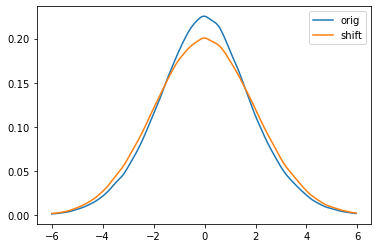

In [11]:
 # Let's base noise std on feature4
density = sp.stats.gaussian_kde(x3[30000:,3])
x = np.arange(-6, 6, .05)
plt.plot(x, density(x), label='orig')

density = sp.stats.gaussian_kde(x3[:-30000,3])
plt.plot(x, density(x), label='shift')
plt.legend()
plt.show()

In [12]:
# Adding gaussian noise
rng = np.random.default_rng(seed=SEED+2)
s1 = np.square(x3[:,3])
t2 = rng.normal(loc=t1, scale=s1, size=180000)

In [13]:
# overall abs error
mean_absolute_error(
    y_true=t1,
    y_pred=t2)

2.8451920449652643

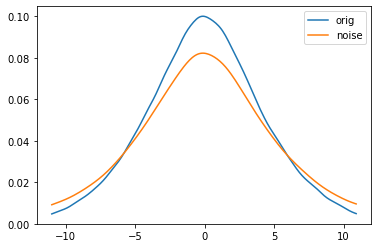

In [14]:
density = sp.stats.gaussian_kde(t1)
x = np.arange(-11, 11, .1)
plt.plot(x, density(x), label='orig')

density = sp.stats.gaussian_kde(t2)
plt.plot(x, density(x), label='noise')
plt.legend()
plt.show()

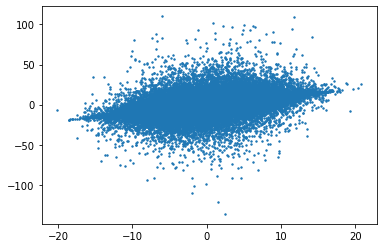

In [15]:
plt.scatter(t1, t2, s=2)

# Let's convert into a dataset

In [16]:
data = data.assign(partition = 'train')
data.loc[60000:, 'partition'] ='reference'
data.loc[120000:, 'partition'] ='analysis'
data.partition.value_counts()

train        60000
reference    60000
analysis     60000
Name: partition, dtype: int64

<AxesSubplot:ylabel='Density'>

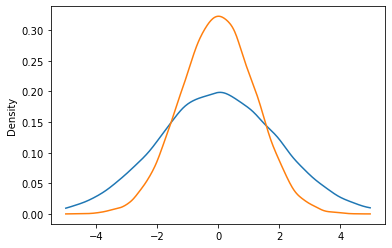

In [17]:
data.feature4[:30000].plot.kde(ind=np.arange(-5, 5, 0.02))
data.feature4[-30000:].plot.kde(ind=np.arange(-5, 5, 0.02))

In [18]:
data = data.assign(y_true = t2)
data = data.assign(y_std = s1)

data.head()

,feature1,feature2,feature3,feature4,partition,y_true,y_std
0,1.220802,2.190876,0.360013,3.292751,train,-14.210923,10.842207
1,0.461790,3.782660,2.599774,3.282467,train,19.331988,10.774591
2,3.711265,-2.599387,-3.467779,0.871672,train,-11.321392,0.759812
3,1.448967,-0.240156,0.446262,-2.591261,train,1.631834,6.714633
4,-0.106896,-0.737643,-0.548846,-1.156195,train,0.604102,1.336787


In [19]:
gbm = GradientBoostingRegressor(random_state=SEED+4)
gbm.fit(
    X=data.loc[data.partition == 'train', feature_names].to_numpy(),
    y=data.loc[data.partition == 'train', ['y_true']].to_numpy().ravel()
)

GradientBoostingRegressor(random_state=1430)

In [20]:
preds = gbm.predict(data[feature_names].to_numpy())
data = data.assign(y_pred = preds)
display(preds.shape)
data.head()

(180000,)

,feature1,feature2,feature3,feature4,partition,y_true,y_std,y_pred
0,1.220802,2.190876,0.360013,3.292751,train,-14.210923,10.842207,1.804019
1,0.461790,3.782660,2.599774,3.282467,train,19.331988,10.774591,7.361359
2,3.711265,-2.599387,-3.467779,0.871672,train,-11.321392,0.759812,-9.831324
3,1.448967,-0.240156,0.446262,-2.591261,train,1.631834,6.714633,-0.627180
4,-0.106896,-0.737643,-0.548846,-1.156195,train,0.604102,1.336787,-0.904592


In [21]:
# add artificiacl timestamp
timestamps = [dt.datetime(2020,1,1) + dt.timedelta(weeks=x/6000) for x in data.index]
data['timestamp'] = timestamps
data.tail(3)

,feature1,feature2,feature3,feature4,partition,y_true,y_std,y_pred,timestamp
179997,-1.603126,-3.259720,-1.519413,-1.670753,analysis,-6.851495,2.791414,-4.136851,2020-07-28 23:54:57.600
179998,0.604372,1.123468,2.184232,2.148200,analysis,4.991351,4.614764,2.125917,2020-07-28 23:56:38.400
179999,-0.756963,-1.916099,-0.259686,-0.627646,analysis,-2.596157,0.393940,-3.290826,2020-07-28 23:58:19.200


In [22]:
data.to_csv('data.csv', index=False)